In [52]:
#Import Data and Libraries
import math
import scipy
import scipy.io
import scipy.signal as s
import scipy.integrate as integrate
import scipy.interpolate as interp
import matplotlib.pyplot as plt

import statsmodels.api as sm
import numpy as np

def todB(x): return 10 * np.log10(abs(x))
def amp(x): return 10**(x/10)

def t90(x,peak):
    #total = scipy.integrate.simps(x,dx=1/fs,even='avg')
    total = sum(x)
    #print(total)
    for i in range(1,peak):
        #if(scipy.integrate.simps(x[peak-i:peak+i],dx=1/fs,even='avg')>=(0.9*total)):
        if(sum(x[peak-i:peak+i])>=(0.9*total)):
            return 2*i/fs
    return -99999
#   t90(x,peak) gradually increases a symetric window around the peak untill it reaches 90% of the total
#   returns the window size in units of time

full = scipy.io.loadmat('23B_121_86_FullGun.mat')
partial = scipy.io.loadmat('23B_123_409_NoGun.mat')

test = scipy.io.loadmat('MGL1212_Line_AT.mat')

f1 = full['Data1']
f2 = full['Data2']

p1 = partial['Data1']
p2 = partial['Data2']

f1 = test['Data1']

f1 = f1*(10**6) #convert to micro pascals
fs = 250


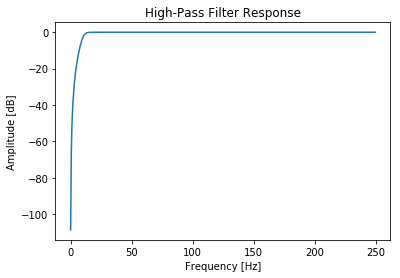

In [53]:
# I. High Pass Filter to remove streamer noise

#Applies 5th order high pass butterworth filter with 11hz cutoff to remove streamer noise

b,a = s.butter(5,Wn=11/fs,btype='highpass')#,analog=True
w,h = s.freqz(b,a)

fig = plt.figure()
plt.title('High-Pass Filter Response')

plt.plot(w*fs/(math.pi),todB(h))
plt.ylabel('Amplitude [dB]')
plt.xlabel('Frequency [Hz]')
plt.show()

fData = []
for column in f1.T:
    #print(column)
    fData.append(s.filtfilt(b,a,column))
fData = np.transpose(fData)
#fData = f1#####

In [54]:
# II. Adjusting for group length (+6dB)
fData = amp(6)*fData


In [55]:
# III. Windowing Around Peak (2s before and after)

winData = []
peak = []
for column in fData.T:
    peak1 = np.argmax(column[3000:4500])+3000 #look for peak near 15s
    #print(peak1)
    PRE = np.zeros(peak1-2*fs-1)
    DATA = column[peak1-2*fs:peak1+2*fs]
    POST = np.zeros(len(column)-(peak1+2*fs)+1)
    k = np.concatenate((PRE,DATA,POST),axis=0)#creates windowed channel
    winData.append(k)
    peak.append(peak1)
winData = np.transpose(winData)
#print(peak)

In [56]:
# IV. Calculate RMS Density

squaredPressure = winData**2
RMS = []
T90 = []
#T90a=0.1 #static t90
i = 0

for column in squaredPressure.T:
    T90a=t90(column,peak[i])
    #print(i)
    #RMS.append(scipy.integrate.simps(column,dx=1/fs)/T90a)#,even='avg'
    RMS.append(sum(column)/((T90a)*fs))
    i = i+1
    T90.append(T90a)
RMS = 10*np.log10(RMS)
print(RMS)
#print(T90) 

[ 160.04177181  160.35848946  161.04617111  161.28340461  160.22718322
  161.4270975   161.57512602  161.20051369  161.12944421  152.22469486
  161.09839728  152.68069399  138.99899121  160.14086587  155.26150915
  147.69157361  149.92710409  159.54547952  161.53767616  139.08062231
  161.1862242   149.74787995  160.83964355  150.98571138  159.68005525
  159.82175164  158.53062537  159.21167033  141.94326117  146.91682445
  159.62319131  158.91933414  159.10976141  160.07896625  158.49032523
  137.67014177  159.67182228  160.87356818  159.9185281   160.32818062
  160.61092223  160.00450994  160.33042026  160.0194304   135.97440513
  160.42632326  160.06537021  135.92520774  159.82276263  159.55405657
  159.99599044  159.97319789  136.29875273  160.00722937  159.9744403
  159.76793329  159.97227125  160.15708135  159.5340079   135.73023504
  157.36041186  134.38611426  154.96925262  158.47160675  158.69999638
  157.34555555  157.613889    135.13669992  157.37869055  157.25622611
  155.0

In [57]:
#IV. Calculate SEL Energy Density (dB)

SEL=[]

i = 0
for column in RMS.T:
    SEL.append(column+10*np.log10(T90[i]))
    i = i+1

print(SEL)

scipy.io.savemat('Data.mat', mdict={'SEL':SEL,'RMS':RMS,'Windowed': winData,'Filtered':fData,'Original':f1})#debug

[162.21134388808142, 162.52806153369997, 163.31989553296592, 163.45297667974503, 162.48027603419277, 163.61770082823287, 163.91016361984461, 163.77249795434471, 163.60426682043277, 158.21915861287744, 163.68955572083712, 158.68388728648378, 144.99345496575208, 163.25416538907663, 158.74845105436304, 151.7330661004824, 153.62668015944021, 162.92206842693554, 164.93020249881607, 145.03117320346021, 164.65757202709571, 155.67186841362573, 164.61270605788508, 156.92742616927544, 164.26189960695473, 164.15464849501174, 163.59296896906477, 163.55735936711417, 147.9026302290074, 152.87619351315709, 164.21711619059815, 163.3784882746327, 163.82267851862207, 164.51316086719416, 163.21496419420077, 143.49532061088192, 164.81995522764362, 165.38221510131066, 164.74726393199114, 165.12249399557376, 165.41674009582741, 164.83324577108917, 164.92434513765932, 165.01630122501101, 141.78137452280566, 165.42319408971463, 165.1277138031223, 141.74129140067933, 165.02366590980867, 164.78631698694127, 165

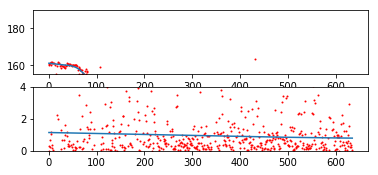

[9, 11, 12, 14, 15, 16, 19, 21, 23, 28, 29, 35, 44, 47, 52, 59, 61, 67, 73, 74, 76, 77, 80, 81, 82, 83, 84, 89, 90, 91, 92, 96, 97, 98, 99, 100, 101, 103, 105, 106, 107, 108, 115, 116, 118, 119, 120, 121, 124, 125, 140, 142, 143, 144, 151, 161, 163, 172, 175, 177, 181, 192, 199, 201, 202, 203, 224, 233, 236, 250, 252, 266, 268, 316, 341, 342, 344, 348, 359, 389, 390, 391, 393, 396, 397, 398, 399, 400, 431, 432, 447, 551, 553, 560, 582, 583, 584, 588, 589, 591, 635] 
 [10, 13, 17, 20, 22, 24, 30, 36, 45, 48, 53, 60, 62, 63, 68, 75, 78, 85, 93, 102, 104, 109, 117, 122, 128, 129, 141, 145, 152, 162, 164, 167, 168, 173, 176, 178, 182, 185, 186, 193, 194, 195, 200, 205, 213, 214, 215, 220, 225, 234, 237, 251, 253, 267, 269, 317, 343, 345, 349, 360, 362, 380, 392, 401, 402, 403, 416, 426, 433, 437, 448, 473, 485, 488, 489, 490, 497, 498, 522, 523, 528, 533, 535, 536, 552, 554, 557, 561, 562, 563, 585, 590, 592, 613, 629]


In [58]:
#V. Remove noisy or inaccurate channels
#RMS Differentials
noisy = []
inaccurate = []#keeps track of indicies
RMS2 = RMS.tolist() #without noisy and inaccurate channels
SEL2 = SEL#.tolist()
RMS_diff = [0]
r1 = 0
#k = #636
for r2 in range(1,636):
    RMS_diff.append(abs(RMS[r1]-RMS[r2]))
    r1 = r1+1
    
#local regression for RMS and RMS_diff
lowess = sm.nonparametric.lowess
b = np.linspace(0,635,636)
fit = lowess(RMS,b,is_sorted=True,return_sorted=False, frac=0.1)
fitd = lowess(RMS_diff,b,is_sorted=True,return_sorted=False,frac=1)


#Plots
plt.subplot(3,1,1)
plt.plot(b,fit)
plt.scatter(b,RMS,s=1,color='r')
plt.ylim(155,190)
plt.subplot(3,1,2)
plt.plot(b,fitd)
plt.scatter(b,RMS_diff,s=1,color='r')
plt.ylim(0,4)

#Remove bad channels

largeDelta = ((RMS2-fit)**2>=10)
largeDelta2 = ((RMS_diff-fitd)**2>=2)

for i in range(0,636):
    if(largeDelta[i]):
        inaccurate.append(i)
        RMS2[i]=(RMS2[i-1]+RMS2[i-1])/2
        SEL2[i]=(SEL2[i-1]+SEL2[i-1])/2
    if(largeDelta2[i] and not(largeDelta[i])):
        noisy.append(i)
        RMS2[i]=(RMS2[i-1]+RMS2[i-1])/2
        
        
        
        
        SEL2[i]=(SEL2[i-1]+SEL2[i-1])/2
plt.show()
print(inaccurate,'\n',noisy)


SEL180 = -0.0125
SEL160 = 1.05
RMS180 = -0.0125
RMS160 = 0.36250000000000004


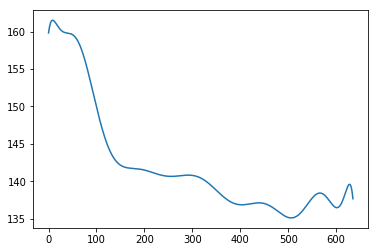

In [59]:
#VI. Fitting Data
#SELspl = interp.UnivariateSpline(SEL2,b)# callable type
#RMSspl = interp.UnivariateSpline(RMS2,b)
#print(b.shape,' ',RMS2.shape)
#for i in innacurate:
    
#SELpol = interp.interp1d(b,SEL2,kind='nearest',assume_sorted=True,fill_value='extrapolate')
#RMSpol = interp.interp1d(b,RMS2,kind='nearest',assume_sorted=True,fill_value='extrapolate')

SELmodel = np.polyfit(b, SEL2, deg=15)#,rcond=2e-16) 
RMSmodel = np.polyfit(b, RMS2, deg=15)#,rcond=2e-16)

SELpol = np.poly1d(SELmodel) 
RMSpol = np.poly1d(RMSmodel)

SEL180 = -1
SEL160 = -1
RMS180 = -1
RMS160 = -1

for i in range(0,1000):
    #print(SELpol(i))
    if(SELpol(i)>180):
        SEL180 = i
    if(SELpol(i)>160):
        SEL160 = i
    if(RMSpol(i)>180):
        RMS180 = i
    if(RMSpol(i)>160):
        RMS160 = i
SEL180 = SEL180*(12.5/1000)#converts from index to length in km
SEL160 = SEL160*(12.5/1000)
RMS180 = RMS180*(12.5/1000)
RMS160 = RMS160*(12.5/1000)

print('SEL180 =',SEL180)
print('SEL160 =',SEL160)
print('RMS180 =',RMS180)
print('RMS160 =',RMS160)

plt.plot(b,RMSpol(b))
plt.show()

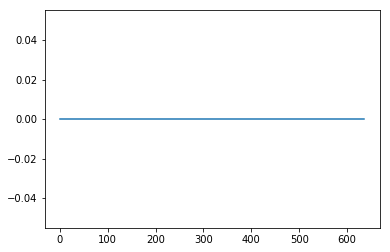

In [60]:
#print(f1[1])
plt.plot(np.linspace(0,636,636),f1[1])
plt.show()